# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.GELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.GELU(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.GELU(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.GELU(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9388
Epoch 1/200, Iteration 2/12, Loss: 0.9332
Epoch 1/200, Iteration 3/12, Loss: 1.0245
Epoch 1/200, Iteration 4/12, Loss: 0.3665
Epoch 1/200, Iteration 5/12, Loss: 0.9576
Epoch 1/200, Iteration 6/12, Loss: 0.5296
Epoch 1/200, Iteration 7/12, Loss: 0.6131
Epoch 1/200, Iteration 8/12, Loss: 0.8461
Epoch 1/200, Iteration 9/12, Loss: 0.5064
Epoch 1/200, Iteration 10/12, Loss: 0.4067
Epoch 1/200, Iteration 11/12, Loss: 0.2979
Epoch 1/200, Iteration 12/12, Loss: 0.3543
Epoch 1/200, Iteration 13/12, Loss: 0.3604
Train Error: 
 Accuracy: 69.75%, Avg loss: 0.228304, MRE: 0.343766, MAE: 0.056587 

Test Error: 
 Accuracy: 69.0%, Avg loss: 0.253692, MRE: 0.280892, MAE: 0.059202 

Epoch 2/200, Iteration 1/12, Loss: 0.2296
Epoch 2/200, Iteration 2/12, Loss: 0.2540
Epoch 2/200, Iteration 3/12, Loss: 0.2422
Epoch 2/200, Iteration 4/12, Loss: 0.2254
Epoch 2/200, Iteration 5/12, Loss: 0.1352
Epoch 2/200, Iteration 6/12, Loss: 0.2033
Epoch 2/200, Iteration 7/12, Los

Epoch 12/200, Iteration 9/12, Loss: 0.0010
Epoch 12/200, Iteration 10/12, Loss: 0.0022
Epoch 12/200, Iteration 11/12, Loss: 0.0024
Epoch 12/200, Iteration 12/12, Loss: 0.0019
Epoch 12/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.002248, MRE: 0.028354, MAE: 0.005152 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002123, MRE: 0.022673, MAE: 0.005063 

Epoch 13/200, Iteration 1/12, Loss: 0.0020
Epoch 13/200, Iteration 2/12, Loss: 0.0035
Epoch 13/200, Iteration 3/12, Loss: 0.0010
Epoch 13/200, Iteration 4/12, Loss: 0.0025
Epoch 13/200, Iteration 5/12, Loss: 0.0016
Epoch 13/200, Iteration 6/12, Loss: 0.0017
Epoch 13/200, Iteration 7/12, Loss: 0.0017
Epoch 13/200, Iteration 8/12, Loss: 0.0015
Epoch 13/200, Iteration 9/12, Loss: 0.0011
Epoch 13/200, Iteration 10/12, Loss: 0.0017
Epoch 13/200, Iteration 11/12, Loss: 0.0023
Epoch 13/200, Iteration 12/12, Loss: 0.0009
Epoch 13/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 97.62%, Avg loss: 0.001787

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.008152, MRE: 0.041281, MAE: 0.008662 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006736, MRE: 0.031883, MAE: 0.007351 

Epoch 24/200, Iteration 1/12, Loss: 0.0083
Epoch 24/200, Iteration 2/12, Loss: 0.0064
Epoch 24/200, Iteration 3/12, Loss: 0.0066
Epoch 24/200, Iteration 4/12, Loss: 0.0047
Epoch 24/200, Iteration 5/12, Loss: 0.0062
Epoch 24/200, Iteration 6/12, Loss: 0.0091
Epoch 24/200, Iteration 7/12, Loss: 0.0060
Epoch 24/200, Iteration 8/12, Loss: 0.0090
Epoch 24/200, Iteration 9/12, Loss: 0.0066
Epoch 24/200, Iteration 10/12, Loss: 0.0054
Epoch 24/200, Iteration 11/12, Loss: 0.0077
Epoch 24/200, Iteration 12/12, Loss: 0.0061
Epoch 24/200, Iteration 13/12, Loss: 0.0044
Train Error: 
 Accuracy: 93.62%, Avg loss: 0.005879, MRE: 0.051284, MAE: 0.007076 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.004601, MRE: 0.038227, MAE: 0.006512 

Epoch 25/200, Iteration 1/12, Loss: 0.0044
Epoch 25/200, Iteration 2/12, Loss: 0.0045
Epoch 25/200, Itera

Epoch 35/200, Iteration 3/12, Loss: 0.0001
Epoch 35/200, Iteration 4/12, Loss: 0.0002
Epoch 35/200, Iteration 5/12, Loss: 0.0001
Epoch 35/200, Iteration 6/12, Loss: 0.0001
Epoch 35/200, Iteration 7/12, Loss: 0.0001
Epoch 35/200, Iteration 8/12, Loss: 0.0001
Epoch 35/200, Iteration 9/12, Loss: 0.0002
Epoch 35/200, Iteration 10/12, Loss: 0.0002
Epoch 35/200, Iteration 11/12, Loss: 0.0001
Epoch 35/200, Iteration 12/12, Loss: 0.0001
Epoch 35/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000116, MRE: 0.007504, MAE: 0.000972 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000118, MRE: 0.005530, MAE: 0.001107 

Epoch 36/200, Iteration 1/12, Loss: 0.0001
Epoch 36/200, Iteration 2/12, Loss: 0.0001
Epoch 36/200, Iteration 3/12, Loss: 0.0001
Epoch 36/200, Iteration 4/12, Loss: 0.0001
Epoch 36/200, Iteration 5/12, Loss: 0.0001
Epoch 36/200, Iteration 6/12, Loss: 0.0001
Epoch 36/200, Iteration 7/12, Loss: 0.0001
Epoch 36/200, Iteration 8/12, Loss: 0.0001
Epoch 36/200

Epoch 46/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000094, MRE: 0.007095, MAE: 0.000907 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000096, MRE: 0.005066, MAE: 0.000994 

Epoch 47/200, Iteration 1/12, Loss: 0.0002
Epoch 47/200, Iteration 2/12, Loss: 0.0001
Epoch 47/200, Iteration 3/12, Loss: 0.0001
Epoch 47/200, Iteration 4/12, Loss: 0.0001
Epoch 47/200, Iteration 5/12, Loss: 0.0001
Epoch 47/200, Iteration 6/12, Loss: 0.0000
Epoch 47/200, Iteration 7/12, Loss: 0.0001
Epoch 47/200, Iteration 8/12, Loss: 0.0001
Epoch 47/200, Iteration 9/12, Loss: 0.0001
Epoch 47/200, Iteration 10/12, Loss: 0.0001
Epoch 47/200, Iteration 11/12, Loss: 0.0001
Epoch 47/200, Iteration 12/12, Loss: 0.0000
Epoch 47/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000075, MRE: 0.006710, MAE: 0.000809 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000074, MRE: 0.004415, MAE: 0.000886 

Epoch 48/200, Iteration 1/12, Loss: 0.0001
Epoch 48/200, It

Epoch 58/200, Iteration 3/12, Loss: 0.0000
Epoch 58/200, Iteration 4/12, Loss: 0.0001
Epoch 58/200, Iteration 5/12, Loss: 0.0001
Epoch 58/200, Iteration 6/12, Loss: 0.0000
Epoch 58/200, Iteration 7/12, Loss: 0.0001
Epoch 58/200, Iteration 8/12, Loss: 0.0000
Epoch 58/200, Iteration 9/12, Loss: 0.0001
Epoch 58/200, Iteration 10/12, Loss: 0.0001
Epoch 58/200, Iteration 11/12, Loss: 0.0001
Epoch 58/200, Iteration 12/12, Loss: 0.0000
Epoch 58/200, Iteration 13/12, Loss: 0.0002
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000056, MRE: 0.006256, MAE: 0.000665 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000057, MRE: 0.003935, MAE: 0.000736 

Epoch 59/200, Iteration 1/12, Loss: 0.0000
Epoch 59/200, Iteration 2/12, Loss: 0.0000
Epoch 59/200, Iteration 3/12, Loss: 0.0001
Epoch 59/200, Iteration 4/12, Loss: 0.0001
Epoch 59/200, Iteration 5/12, Loss: 0.0001
Epoch 59/200, Iteration 6/12, Loss: 0.0001
Epoch 59/200, Iteration 7/12, Loss: 0.0001
Epoch 59/200, Iteration 8/12, Loss: 0.0001
Epoch 59/200

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000061, MRE: 0.006521, MAE: 0.000753 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000064, MRE: 0.004384, MAE: 0.000819 

Epoch 70/200, Iteration 1/12, Loss: 0.0001
Epoch 70/200, Iteration 2/12, Loss: 0.0001
Epoch 70/200, Iteration 3/12, Loss: 0.0001
Epoch 70/200, Iteration 4/12, Loss: 0.0001
Epoch 70/200, Iteration 5/12, Loss: 0.0001
Epoch 70/200, Iteration 6/12, Loss: 0.0000
Epoch 70/200, Iteration 7/12, Loss: 0.0001
Epoch 70/200, Iteration 8/12, Loss: 0.0001
Epoch 70/200, Iteration 9/12, Loss: 0.0001
Epoch 70/200, Iteration 10/12, Loss: 0.0001
Epoch 70/200, Iteration 11/12, Loss: 0.0000
Epoch 70/200, Iteration 12/12, Loss: 0.0001
Epoch 70/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000055, MRE: 0.006325, MAE: 0.000731 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000054, MRE: 0.003804, MAE: 0.000768 

Epoch 71/200, Iteration 1/12, Loss: 0.0000
Epoch 71/200, Iteration 2/12, Loss: 0.0000
Epoch 71/200, Ite

Epoch 81/200, Iteration 4/12, Loss: 0.0000
Epoch 81/200, Iteration 5/12, Loss: 0.0000
Epoch 81/200, Iteration 6/12, Loss: 0.0000
Epoch 81/200, Iteration 7/12, Loss: 0.0001
Epoch 81/200, Iteration 8/12, Loss: 0.0000
Epoch 81/200, Iteration 9/12, Loss: 0.0001
Epoch 81/200, Iteration 10/12, Loss: 0.0001
Epoch 81/200, Iteration 11/12, Loss: 0.0000
Epoch 81/200, Iteration 12/12, Loss: 0.0000
Epoch 81/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.005719, MAE: 0.000605 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.003645, MAE: 0.000648 

Epoch 82/200, Iteration 1/12, Loss: 0.0001
Epoch 82/200, Iteration 2/12, Loss: 0.0001
Epoch 82/200, Iteration 3/12, Loss: 0.0000
Epoch 82/200, Iteration 4/12, Loss: 0.0000
Epoch 82/200, Iteration 5/12, Loss: 0.0000
Epoch 82/200, Iteration 6/12, Loss: 0.0000
Epoch 82/200, Iteration 7/12, Loss: 0.0000
Epoch 82/200, Iteration 8/12, Loss: 0.0000
Epoch 82/200, Iteration 9/12, Loss: 0.0000
Epoch 82/200

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.005690, MAE: 0.000603 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000039, MRE: 0.003435, MAE: 0.000647 

Epoch 93/200, Iteration 1/12, Loss: 0.0000
Epoch 93/200, Iteration 2/12, Loss: 0.0000
Epoch 93/200, Iteration 3/12, Loss: 0.0000
Epoch 93/200, Iteration 4/12, Loss: 0.0000
Epoch 93/200, Iteration 5/12, Loss: 0.0000
Epoch 93/200, Iteration 6/12, Loss: 0.0001
Epoch 93/200, Iteration 7/12, Loss: 0.0000
Epoch 93/200, Iteration 8/12, Loss: 0.0000
Epoch 93/200, Iteration 9/12, Loss: 0.0000
Epoch 93/200, Iteration 10/12, Loss: 0.0000
Epoch 93/200, Iteration 11/12, Loss: 0.0001
Epoch 93/200, Iteration 12/12, Loss: 0.0000
Epoch 93/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000040, MRE: 0.005633, MAE: 0.000614 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000042, MRE: 0.003502, MAE: 0.000674 

Epoch 94/200, Iteration 1/12, Loss: 0.0000
Epoch 94/200, Iteration 2/12, Loss: 0.0000
Epoch 94/200, Ite

Epoch 104/200, Iteration 5/12, Loss: 0.0001
Epoch 104/200, Iteration 6/12, Loss: 0.0001
Epoch 104/200, Iteration 7/12, Loss: 0.0000
Epoch 104/200, Iteration 8/12, Loss: 0.0001
Epoch 104/200, Iteration 9/12, Loss: 0.0001
Epoch 104/200, Iteration 10/12, Loss: 0.0000
Epoch 104/200, Iteration 11/12, Loss: 0.0000
Epoch 104/200, Iteration 12/12, Loss: 0.0001
Epoch 104/200, Iteration 13/12, Loss: 0.0001
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000050, MRE: 0.005665, MAE: 0.000714 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000047, MRE: 0.003541, MAE: 0.000712 

Epoch 105/200, Iteration 1/12, Loss: 0.0000
Epoch 105/200, Iteration 2/12, Loss: 0.0001
Epoch 105/200, Iteration 3/12, Loss: 0.0001
Epoch 105/200, Iteration 4/12, Loss: 0.0000
Epoch 105/200, Iteration 5/12, Loss: 0.0000
Epoch 105/200, Iteration 6/12, Loss: 0.0001
Epoch 105/200, Iteration 7/12, Loss: 0.0001
Epoch 105/200, Iteration 8/12, Loss: 0.0000
Epoch 105/200, Iteration 9/12, Loss: 0.0000
Epoch 105/200, Iteration 10/12, Loss:

Epoch 115/200, Iteration 6/12, Loss: 0.0000
Epoch 115/200, Iteration 7/12, Loss: 0.0000
Epoch 115/200, Iteration 8/12, Loss: 0.0000
Epoch 115/200, Iteration 9/12, Loss: 0.0001
Epoch 115/200, Iteration 10/12, Loss: 0.0000
Epoch 115/200, Iteration 11/12, Loss: 0.0001
Epoch 115/200, Iteration 12/12, Loss: 0.0000
Epoch 115/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000044, MRE: 0.005507, MAE: 0.000638 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048, MRE: 0.003716, MAE: 0.000710 

Epoch 116/200, Iteration 1/12, Loss: 0.0000
Epoch 116/200, Iteration 2/12, Loss: 0.0000
Epoch 116/200, Iteration 3/12, Loss: 0.0001
Epoch 116/200, Iteration 4/12, Loss: 0.0000
Epoch 116/200, Iteration 5/12, Loss: 0.0000
Epoch 116/200, Iteration 6/12, Loss: 0.0000
Epoch 116/200, Iteration 7/12, Loss: 0.0000
Epoch 116/200, Iteration 8/12, Loss: 0.0000
Epoch 116/200, Iteration 9/12, Loss: 0.0000
Epoch 116/200, Iteration 10/12, Loss: 0.0000
Epoch 116/200, Iteration 11/12, Loss

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.004616, MAE: 0.000444 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.002775, MAE: 0.000494 

Epoch 127/200, Iteration 1/12, Loss: 0.0000
Epoch 127/200, Iteration 2/12, Loss: 0.0000
Epoch 127/200, Iteration 3/12, Loss: 0.0000
Epoch 127/200, Iteration 4/12, Loss: 0.0000
Epoch 127/200, Iteration 5/12, Loss: 0.0000
Epoch 127/200, Iteration 6/12, Loss: 0.0001
Epoch 127/200, Iteration 7/12, Loss: 0.0000
Epoch 127/200, Iteration 8/12, Loss: 0.0000
Epoch 127/200, Iteration 9/12, Loss: 0.0000
Epoch 127/200, Iteration 10/12, Loss: 0.0000
Epoch 127/200, Iteration 11/12, Loss: 0.0000
Epoch 127/200, Iteration 12/12, Loss: 0.0000
Epoch 127/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.004757, MAE: 0.000442 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.002757, MAE: 0.000496 

Epoch 128/200, Iteration 1/12, Loss: 0.0000
Epoch 128/200, Iteration 2/12, Loss: 0.0001
Ep

Epoch 138/200, Iteration 5/12, Loss: 0.0000
Epoch 138/200, Iteration 6/12, Loss: 0.0000
Epoch 138/200, Iteration 7/12, Loss: 0.0000
Epoch 138/200, Iteration 8/12, Loss: 0.0000
Epoch 138/200, Iteration 9/12, Loss: 0.0000
Epoch 138/200, Iteration 10/12, Loss: 0.0000
Epoch 138/200, Iteration 11/12, Loss: 0.0000
Epoch 138/200, Iteration 12/12, Loss: 0.0000
Epoch 138/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.004581, MAE: 0.000442 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000027, MRE: 0.002769, MAE: 0.000491 

Epoch 139/200, Iteration 1/12, Loss: 0.0000
Epoch 139/200, Iteration 2/12, Loss: 0.0000
Epoch 139/200, Iteration 3/12, Loss: 0.0000
Epoch 139/200, Iteration 4/12, Loss: 0.0000
Epoch 139/200, Iteration 5/12, Loss: 0.0001
Epoch 139/200, Iteration 6/12, Loss: 0.0000
Epoch 139/200, Iteration 7/12, Loss: 0.0000
Epoch 139/200, Iteration 8/12, Loss: 0.0000
Epoch 139/200, Iteration 9/12, Loss: 0.0000
Epoch 139/200, Iteration 10/12, Loss:

Epoch 149/200, Iteration 7/12, Loss: 0.0000
Epoch 149/200, Iteration 8/12, Loss: 0.0000
Epoch 149/200, Iteration 9/12, Loss: 0.0000
Epoch 149/200, Iteration 10/12, Loss: 0.0000
Epoch 149/200, Iteration 11/12, Loss: 0.0000
Epoch 149/200, Iteration 12/12, Loss: 0.0000
Epoch 149/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004573, MAE: 0.000435 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002744, MAE: 0.000488 

Epoch 150/200, Iteration 1/12, Loss: 0.0000
Epoch 150/200, Iteration 2/12, Loss: 0.0000
Epoch 150/200, Iteration 3/12, Loss: 0.0000
Epoch 150/200, Iteration 4/12, Loss: 0.0000
Epoch 150/200, Iteration 5/12, Loss: 0.0000
Epoch 150/200, Iteration 6/12, Loss: 0.0000
Epoch 150/200, Iteration 7/12, Loss: 0.0000
Epoch 150/200, Iteration 8/12, Loss: 0.0000
Epoch 150/200, Iteration 9/12, Loss: 0.0001
Epoch 150/200, Iteration 10/12, Loss: 0.0000
Epoch 150/200, Iteration 11/12, Loss: 0.0000
Epoch 150/200, Iteration 12/12, Los

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000024, MRE: 0.004598, MAE: 0.000437 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002742, MAE: 0.000495 

Epoch 161/200, Iteration 1/12, Loss: 0.0000
Epoch 161/200, Iteration 2/12, Loss: 0.0000
Epoch 161/200, Iteration 3/12, Loss: 0.0000
Epoch 161/200, Iteration 4/12, Loss: 0.0000
Epoch 161/200, Iteration 5/12, Loss: 0.0000
Epoch 161/200, Iteration 6/12, Loss: 0.0001
Epoch 161/200, Iteration 7/12, Loss: 0.0000
Epoch 161/200, Iteration 8/12, Loss: 0.0000
Epoch 161/200, Iteration 9/12, Loss: 0.0000
Epoch 161/200, Iteration 10/12, Loss: 0.0000
Epoch 161/200, Iteration 11/12, Loss: 0.0000
Epoch 161/200, Iteration 12/12, Loss: 0.0000
Epoch 161/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004560, MAE: 0.000435 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002724, MAE: 0.000481 

Epoch 162/200, Iteration 1/12, Loss: 0.0000
Epoch 162/200, Iteration 2/12, Loss: 0.0000
Ep

Epoch 172/200, Iteration 6/12, Loss: 0.0000
Epoch 172/200, Iteration 7/12, Loss: 0.0000
Epoch 172/200, Iteration 8/12, Loss: 0.0000
Epoch 172/200, Iteration 9/12, Loss: 0.0000
Epoch 172/200, Iteration 10/12, Loss: 0.0000
Epoch 172/200, Iteration 11/12, Loss: 0.0000
Epoch 172/200, Iteration 12/12, Loss: 0.0000
Epoch 172/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004525, MAE: 0.000428 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002704, MAE: 0.000478 

Epoch 173/200, Iteration 1/12, Loss: 0.0000
Epoch 173/200, Iteration 2/12, Loss: 0.0000
Epoch 173/200, Iteration 3/12, Loss: 0.0000
Epoch 173/200, Iteration 4/12, Loss: 0.0000
Epoch 173/200, Iteration 5/12, Loss: 0.0000
Epoch 173/200, Iteration 6/12, Loss: 0.0000
Epoch 173/200, Iteration 7/12, Loss: 0.0001
Epoch 173/200, Iteration 8/12, Loss: 0.0000
Epoch 173/200, Iteration 9/12, Loss: 0.0000
Epoch 173/200, Iteration 10/12, Loss: 0.0000
Epoch 173/200, Iteration 11/12, Loss

Epoch 183/200, Iteration 7/12, Loss: 0.0000
Epoch 183/200, Iteration 8/12, Loss: 0.0001
Epoch 183/200, Iteration 9/12, Loss: 0.0000
Epoch 183/200, Iteration 10/12, Loss: 0.0000
Epoch 183/200, Iteration 11/12, Loss: 0.0000
Epoch 183/200, Iteration 12/12, Loss: 0.0000
Epoch 183/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004514, MAE: 0.000431 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000026, MRE: 0.002739, MAE: 0.000481 

Epoch 184/200, Iteration 1/12, Loss: 0.0001
Epoch 184/200, Iteration 2/12, Loss: 0.0000
Epoch 184/200, Iteration 3/12, Loss: 0.0000
Epoch 184/200, Iteration 4/12, Loss: 0.0000
Epoch 184/200, Iteration 5/12, Loss: 0.0000
Epoch 184/200, Iteration 6/12, Loss: 0.0000
Epoch 184/200, Iteration 7/12, Loss: 0.0000
Epoch 184/200, Iteration 8/12, Loss: 0.0000
Epoch 184/200, Iteration 9/12, Loss: 0.0000
Epoch 184/200, Iteration 10/12, Loss: 0.0000
Epoch 184/200, Iteration 11/12, Loss: 0.0000
Epoch 184/200, Iteration 12/12, Los

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000022, MRE: 0.004439, MAE: 0.000424 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002638, MAE: 0.000474 

Epoch 195/200, Iteration 1/12, Loss: 0.0000
Epoch 195/200, Iteration 2/12, Loss: 0.0000
Epoch 195/200, Iteration 3/12, Loss: 0.0000
Epoch 195/200, Iteration 4/12, Loss: 0.0001
Epoch 195/200, Iteration 5/12, Loss: 0.0000
Epoch 195/200, Iteration 6/12, Loss: 0.0000
Epoch 195/200, Iteration 7/12, Loss: 0.0000
Epoch 195/200, Iteration 8/12, Loss: 0.0000
Epoch 195/200, Iteration 9/12, Loss: 0.0000
Epoch 195/200, Iteration 10/12, Loss: 0.0000
Epoch 195/200, Iteration 11/12, Loss: 0.0000
Epoch 195/200, Iteration 12/12, Loss: 0.0000
Epoch 195/200, Iteration 13/12, Loss: 0.0000
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.000023, MRE: 0.004477, MAE: 0.000430 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000025, MRE: 0.002725, MAE: 0.000487 

Epoch 196/200, Iteration 1/12, Loss: 0.0000
Epoch 196/200, Iteration 2/12, Loss: 0.0000
Ep

#### Plots loss vs Epoch

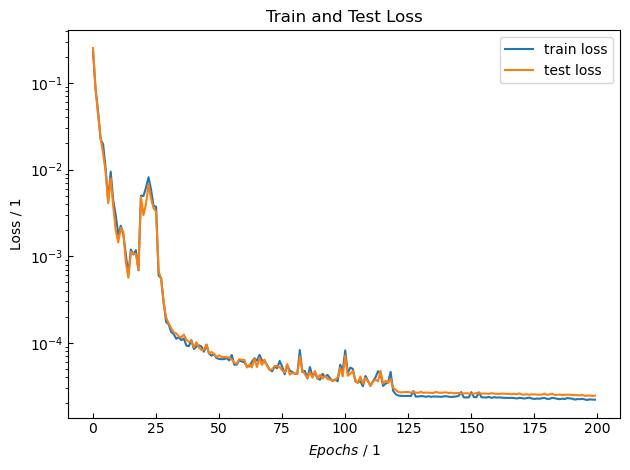

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_024.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999833765733895 , R^2(NH3) = 0.9999722950186474
Test Dataset: R^2(H2) = 0.9999794098374838 , R^2(NH3) = 0.9999756912937481
Max Error Training: |x_H2 - x_H2,pred| = 0.01087626479076198 , |x_NH3 - x_NH3,pred| = 0.003790215799449659
Max Error Test: |x_H2 - x_H2,pred| = 0.003517594345245345 , |x_NH3 - x_NH3,pred| = 0.0014561745546296245


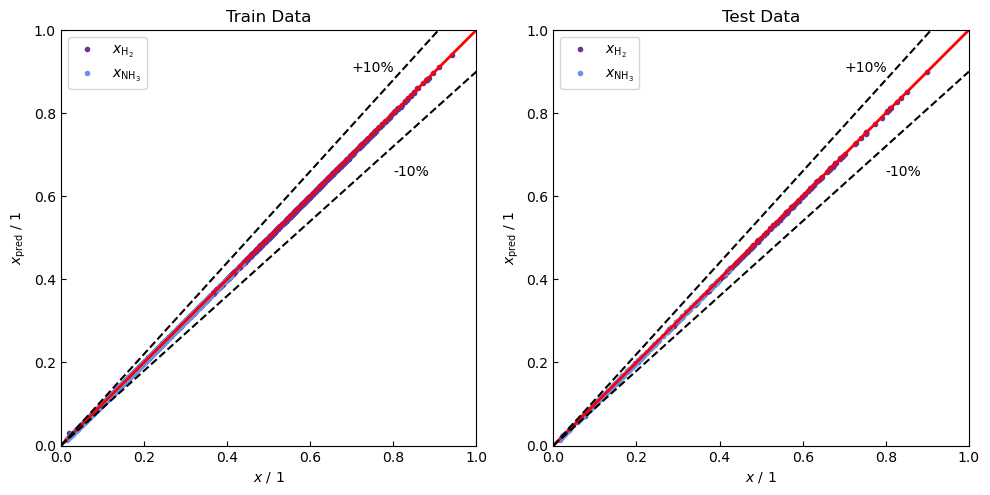

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

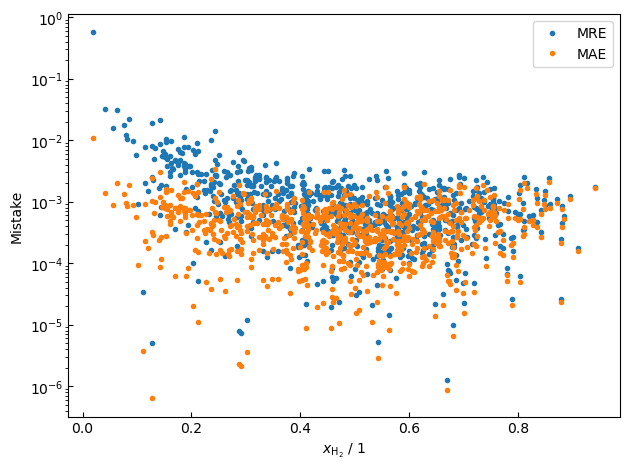

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

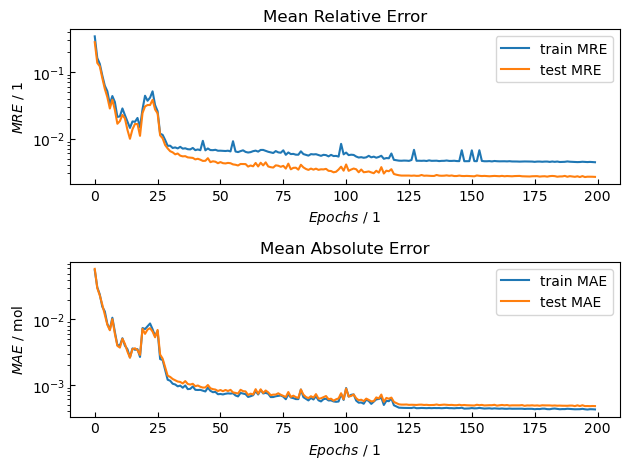

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

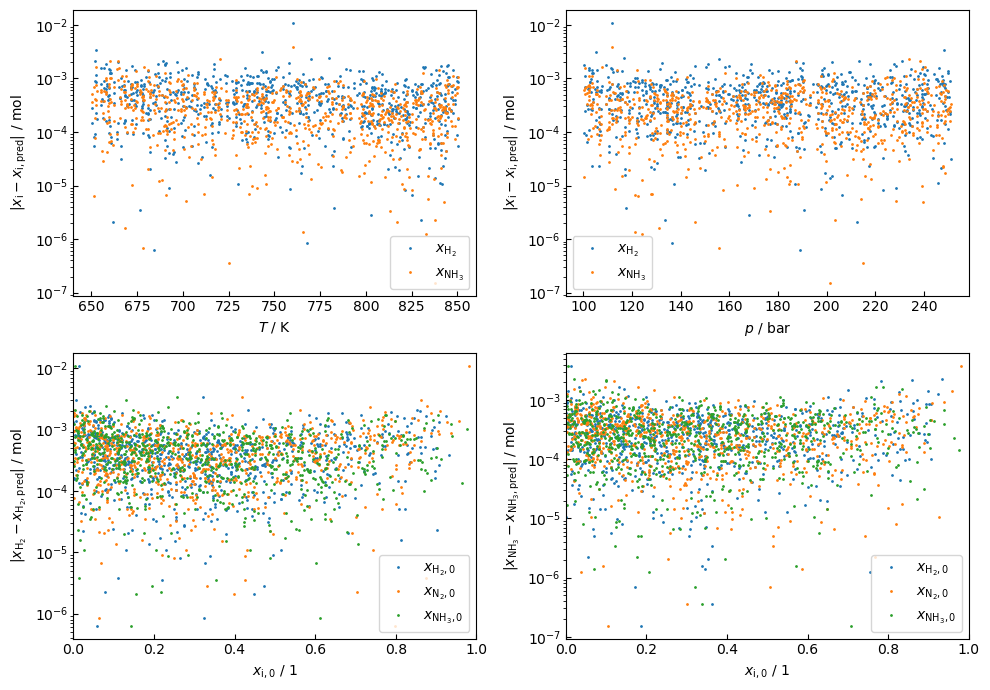

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

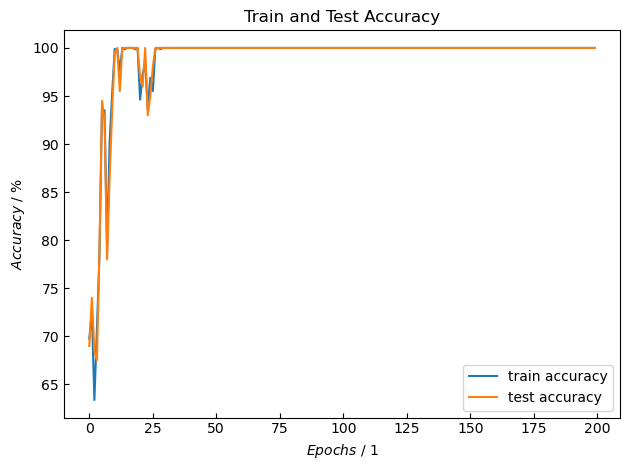

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [17]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.125 s


#### Debugging Hilfe

In [18]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[-1.5105e+00,  5.0681e-01, -1.3877e+00,  1.2629e+00,  7.1097e-02],
        [-1.5350e-01, -1.6948e+00,  1.0160e+00, -1.1813e+00,  2.1034e-01],
        [-7.4091e-01, -5.6096e-01, -1.2218e+00,  2.0842e+00, -9.3118e-01],
        [-9.5454e-01, -8.3328e-01,  3.1355e-01,  1.7803e-01, -4.8967e-01],
        [ 1.5935e+00, -1.3786e+00, -2.3432e-01,  5.5733e-01, -3.3968e-01],
        [ 4.3804e-02, -7.8794e-01, -7.7118e-02,  1.0980e+00, -1.0465e+00],
        [ 1.0139e+00, -4.1590e-01, -5.6929e-01,  1.8430e+00, -1.3250e+00],
        [-2.1849e-01,  1.3309e-01, -1.0097e-02,  1.1138e+00, -1.1284e+00],
        [-8.1081e-01, -1.7842e-01, -8.3894e-01,  7.8785e-01,  1.8079e-02],
        [ 7.7157e-01,  1.3650e+00, -5.9225e-01, -7.2073e-01,  1.3179e+00],
        [-1.3128e+00, -1.0989e+00,  1.0104e-01,  8.2693e-01, -9.4434e-01],
        [-1.6133e+00, -2.8756e-01, -1.3274e+00,  1.4611e+00, -1.9068e-01],
        [-4.7997e-01,  2.0070e-01,  7.7842e-01, -2.3294e-01, -5.2585e-01],
        [ 1.1428e+00,  6.

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-1.4245e-01, -2.1107e-01, -1.6244e-01, -2.2813e-01,  2.3461e-01],
         [ 1.5208e-01, -2.5592e-01,  3.3383e-01, -1.3007e-01,  4.3172e-02],
         [-3.9634e-01, -5.0206e-02,  4.1324e-02,  3.9256e-01, -3.3662e-01],
         [ 8.7224e-02, -3.1460e-01, -2.5799e-01, -1.1581e-01, -2.2331e-01],
         [ 4.1716e-01,  1.1713e-01, -1.1454e-01,  1.3533e-01,  2.2525e-01],
         [ 7.7080e-02,  9.7324e-02,  6.5489e-02,  3.0784e-01,  3.1949e-01],
         [ 3.5470e-01, -2.8749e-02,  4.0404e-01, -2.3030e-01,  2.6634e-01],
         [-4.0070e-02,  1.9440e-01,  3.7578e-01,  1.7529e-01,  1.6392e-01],
         [ 2.3917e-01,  1.2358e-01,  5.3754e-02, -7.6111e-02, -2.6523e-01],
         [ 2.0692e-01, -1.9720e-01, -2.9485e-01, -2.0423e-01,  3.2518e-01],
         [-1.4756e-01,  1.9311e-01,  2.3615e-01,  4.1259e-01, -1.8661e-01],
         [-1.7793e-01, -4.3533e-01, -2.8999e-01,  2.0108e-01,  5.5727e-02],
         [-6.4817e-02,  1.3176e-01, -8.4495e-03, -3.4494e-01, -2.

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4916, 0.5050, 0.2711, 0.3134, 0.6157],
        [0.1178, 0.3442, 0.0177, 0.0418, 0.5912]])
tensor([[ 0.0259, -0.0768],
        [ 0.0315,  0.1842]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.4542e+00,  1.6025e+00, -4.4181e-01,  1.6929e+00, -1.2966e+00],
        [-5.9908e-01,  1.3275e+00,  2.5851e+00, -1.1915e+00, -1.3192e+00],
        [-1.6779e+00, -5.7737e-01,  1.0921e-01,  7.9630e-01, -9.2106e-01],
        [ 7.4725e-02,  5.5401e-01, -6.2231e-01,  2.9287e-01,  3.1139e-01],
        [-3.5059e-01, -3.5045e-02, -6.4317e-03, -3.6549e-01,  3.7987e-01],
        [-1.5800e+00,  8.9613e-01,  8.9739e-01, -4.4323e-01, -4.2767e-01],
        [ 1.6419e-01, -7.1265e-01, -1.1106e+00, -1.0605e+00,  2.1738e+00],
        [-1.1914e+00,  1.3011e+00,  1.3677e+00, -1.1033e+00, -2.1461e-01],
        [ 7.1847e-01,  6.7268e-01,  4.2490e-02, -1.2499e+00,  1.2358e+00],
        [ 1.3873e+00, -9.0413e-01, -8.6729e-01, -6.0638e-01,  1.4709e+00],
        [ 1.2629e+00, -1.3835e+00, -4.1635e-01, -9.2139e-02,  5.0278e-01],
        [-1.1458e+00,  1.7420e-01,  1.3031e+00,  8.9426e-02, -1.3702e+00],
        [-1.3018e+00,  7.0996e-01, -1.1304e+00,  1.7055e+00, -6.3378e-01],
        [-1.2547e+00, -1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

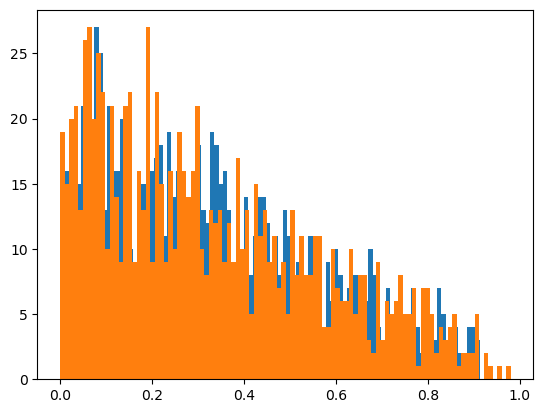

In [23]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [24]:
# torch.save(net.state_dict(),'data/models/ann_005_024.pth')
# np.savez('data/models/params_005_024.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)